# Observed Information with SGHMC

Estimating B hat using observed information matrix. We test the effect of computing the obsered information matrix once, every sample, every step, or not at all.

In [1]:
import sys
sys.path.append("..")

from matplotlib import pyplot as plt
import torch
import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
import numpy as np

from kernel.sghmc import SGHMC

In [2]:
# Coin flip example - we flip two coins indepdenently x1 corresponds to the observed outcomes of coin1 
# and x2 corresponds to the observed outcomes of coin2 
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

# create some data with 2 observed heads and 8 observed tails
x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

    
def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

In [3]:
BATCH_SIZE = 5
# SGHMC without obs info matrix
sghmc_wo_ob = SGHMC(model,
                    subsample_positions=[0, 1],
                    batch_size=BATCH_SIZE,
                    learning_rate=0.01,
                    momentum_decay= 0.1,
                    num_steps=10,
                    resample_every_n=50,
                    obs_info_noise=False,
                    compute_obs_info='every_sample')

sghmc_mcmc_wo_ob = MCMC(sghmc_wo_ob, num_samples=1000)
sghmc_mcmc_wo_ob.run(x1, x2)
sghmc_samples_wo_ob = sghmc_mcmc_wo_ob.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:39, 50.70it/s, lr=1.00e-02]


In [4]:
BATCH_SIZE = 5
# SGHMC obs info matrix computed at the start only
sghmc_with_ob_s = SGHMC(model,
                    subsample_positions=[0, 1],
                    batch_size=BATCH_SIZE,
                    learning_rate=0.01,
                    momentum_decay= 0.1,
                    num_steps=10,
                    resample_every_n=50,
                    obs_info_noise=True,
                    compute_obs_info='start')

sghmc_mcmc_with_ob_s = MCMC(sghmc_with_ob_s, num_samples=1000)
sghmc_mcmc_with_ob_s.run(x1, x2)
sghmc_samples_with_ob_s = sghmc_mcmc_with_ob_s.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:35, 55.64it/s, lr=1.00e-02]


In [5]:
BATCH_SIZE = 5
# SGHMC obs info matrix computed at the start of every sample
sghmc_with_ob_es = SGHMC(model,
                    subsample_positions=[0, 1],
                    batch_size=BATCH_SIZE,
                    learning_rate=0.01,
                    momentum_decay= 0.1,
                    num_steps=10,
                    resample_every_n=50,
                    obs_info_noise=True,
                    compute_obs_info='every_sample')

sghmc_mcmc_with_ob_es = MCMC(sghmc_with_ob_es, num_samples=1000)
sghmc_mcmc_with_ob_es.run(x1, x2)
sghmc_samples_with_ob_es = sghmc_mcmc_with_ob_es.get_samples()
sghmc_obs_info_arr_es = sghmc_with_ob_es.get_obs_info_arr()

Sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:40, 49.99it/s, lr=1.00e-02]
C:\Users\alexw\OneDrive\MSc Oxford\ATML\project\repo\examples\..\kernel\sghmc.py:321: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(self._obs_info_arr)
C:\Users\alexw\OneDrive\MSc Oxford\ATML\project\repo\examples\..\kernel\sghmc.py:321: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

In [7]:
BATCH_SIZE = 5
# SGHMC obs info matrix computed at every leapfrog step
sghmc_with_ob_el = SGHMC(model,
                    subsample_positions=[0, 1],
                    batch_size=BATCH_SIZE,
                    learning_rate=0.01,
                    momentum_decay= 0.1,
                    num_steps=10,
                    resample_every_n=50,
                    obs_info_noise=True,
                    compute_obs_info='every_step')

sghmc_mcmc_with_ob_el = MCMC(sghmc_with_ob_el, num_samples=1000)
sghmc_mcmc_with_ob_el.run(x1, x2)
sghmc_samples_with_ob_el = sghmc_mcmc_with_ob_el.get_samples()
sghmc_obs_info_arr_el = sghmc_with_ob_el.get_obs_info_arr()

Sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [01:28, 22.56it/s, lr=1.00e-02]


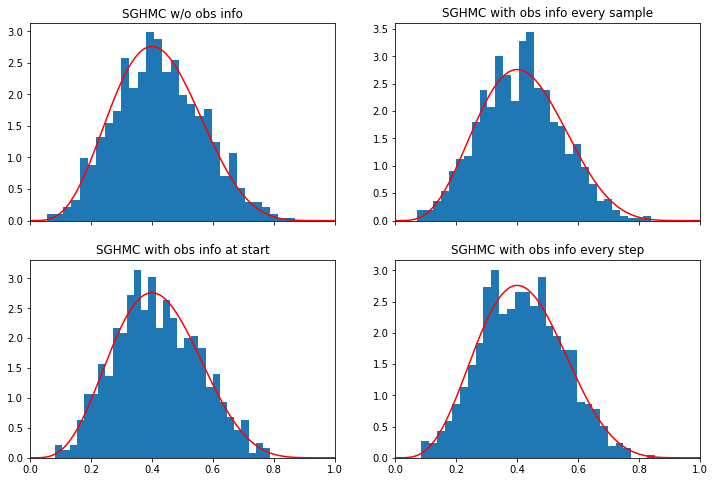

In [8]:
from torch.distributions import Beta

def analytic_posterior(x):
    fn = Beta(5., 7.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
with torch.no_grad():
    axs[0][0].hist(sghmc_samples_wo_ob["coin1"].numpy(), density=True, bins=30)
    axs[0][0].set(title="SGHMC w/o obs info")
    axs[0][0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1][0].hist(sghmc_samples_with_ob_s["coin1"].numpy(), density=True, bins=30)
    axs[1][0].set(title="SGHMC with obs info at start")
    axs[1][0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[0][1].hist(sghmc_samples_with_ob_es["coin1"].numpy(), density=True, bins=30)
    axs[0][1].set(title="SGHMC with obs info every sample")
    axs[0][1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1][1].hist(sghmc_samples_with_ob_el["coin1"].numpy(), density=True, bins=30)
    axs[1][1].set(title="SGHMC with obs info every step")
    axs[1][1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))
plt.show()
#posterior samples should look like a beta(5, 7) dist

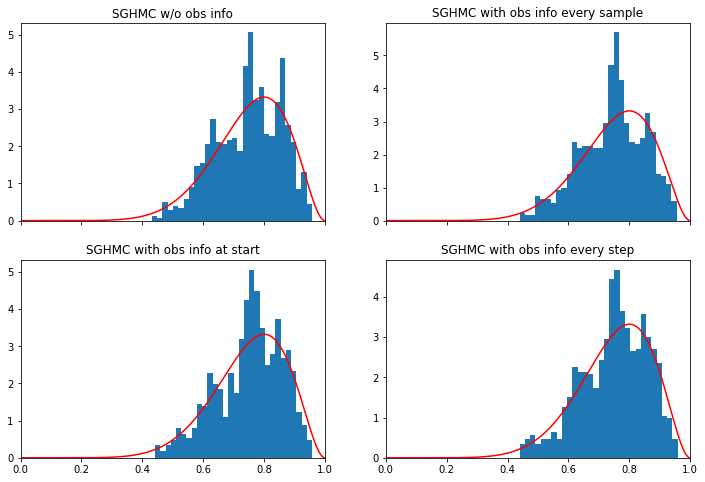

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

def analytic_posterior(x):
    fn = Beta(9., 3.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

with torch.no_grad():
    axs[0][0].hist(sghmc_samples_wo_ob["coin2"].numpy(), density=True, bins=30)
    axs[0][0].set(title="SGHMC w/o obs info")
    axs[0][0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1][0].hist(sghmc_samples_with_ob_s["coin2"].numpy(), density=True, bins=30)
    axs[1][0].set(title="SGHMC with obs info at start")
    axs[1][0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[0][1].hist(sghmc_samples_with_ob_es["coin2"].numpy(), density=True, bins=30)
    axs[0][1].set(title="SGHMC with obs info every sample")
    axs[0][1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1][1].hist(sghmc_samples_with_ob_el["coin2"].numpy(), density=True, bins=30)
    axs[1][1].set(title="SGHMC with obs info every step")
    axs[1][1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))
plt.show()
#posterior samples should look like a beta(9, 3) dist

Plotting how observed info changes when we compute it for every sample

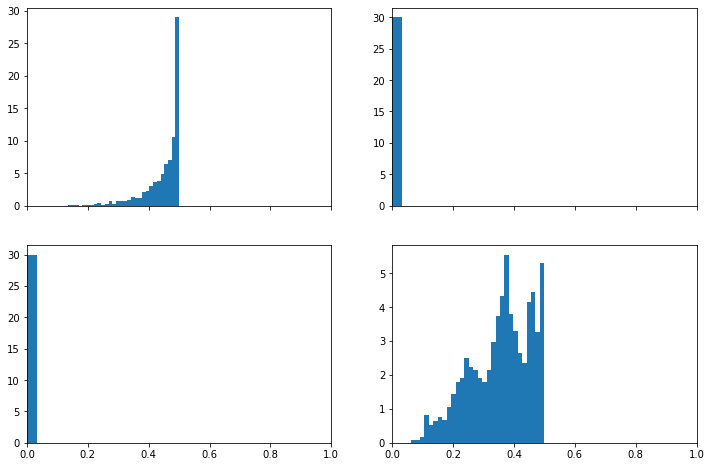

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

def unwrap(arr, x, y):
    return [a[x, y].item() for a in arr]

with torch.no_grad():
    axs[0][0].hist(unwrap(sghmc_obs_info_arr_es, 0, 0), density=True, bins=30)
    axs[1][0].hist(unwrap(sghmc_obs_info_arr_es, 0, 1), density=True, bins=30)
    axs[0][1].hist(unwrap(sghmc_obs_info_arr_es, 1, 0), density=True, bins=30)
    axs[1][1].hist(unwrap(sghmc_obs_info_arr_es, 1, 1), density=True, bins=30)
    
plt.xlim((0.0, 1.0))
plt.show()


Plotting how observed info changes when we compute it for every leapfrog step

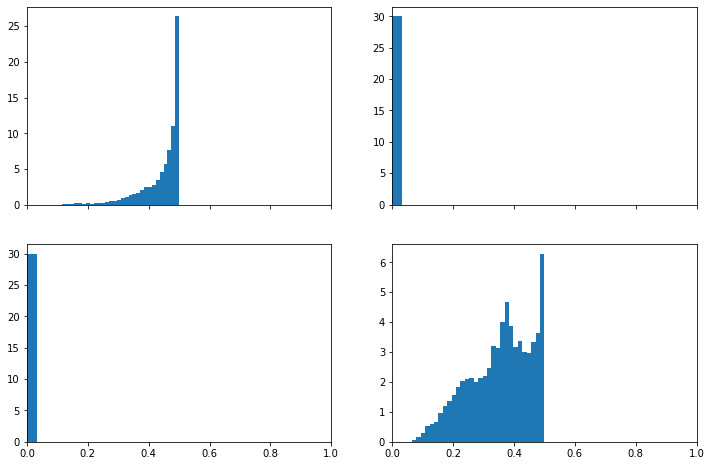

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

def unwrap(arr, x, y):
    return [a[x, y].item() for a in arr]

with torch.no_grad():
    axs[0][0].hist(unwrap(sghmc_obs_info_arr_el, 0, 0), density=True, bins=30)
    axs[1][0].hist(unwrap(sghmc_obs_info_arr_el, 0, 1), density=True, bins=30)
    axs[0][1].hist(unwrap(sghmc_obs_info_arr_el, 1, 0), density=True, bins=30)
    axs[1][1].hist(unwrap(sghmc_obs_info_arr_el, 1, 1), density=True, bins=30)
    
plt.xlim((0.0, 1.0))
plt.show()